MCMC 샘플 중 에너지 상위 50% 부분에서 m+= 50,100,200,400,800,1600,2400 개를 랜덤 샘플링하여 augmentation 하여 inference

In [9]:
# Inverse Ising Inference with High-Energy Augmentation (Erasure Only)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import torch

# -------------------------------
# Ising 모델 샘플링 및 에너지
# -------------------------------

def energy_general_ising(seq, b, w):
    field_term = -np.dot(b, seq)
    interaction_term = -np.sum(np.triu(w, k=1) * np.outer(seq, seq))
    return field_term + interaction_term

def metropolis_sample(L, b, w, beta=1.0, n_steps=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    seq = np.random.choice([-1, 1], size=L)
    local_field = b + np.dot(w, seq)
    for _ in range(n_steps):
        i = np.random.randint(L)
        dE = 2 * seq[i] * local_field[i]
        if dE <= 0 or np.random.rand() < np.exp(-beta * dE):
            seq[i] *= -1
            local_field += 2 * w[:, i] * seq[i]
    return seq

def sample_general_ising(L, N, b, w, beta=1.0, n_steps=1000, n_jobs=10):
    seeds = np.random.randint(0, 1e6, size=N)
    samples = Parallel(n_jobs=n_jobs)(
        delayed(metropolis_sample)(L, b, w, beta, n_steps, seed) for seed in tqdm(seeds, desc="Sampling Ising states", unit="sample")
    )
    return np.array(samples)

def compute_energy(seq, b, w):
    return -np.dot(b, seq) - np.sum(np.triu(w, k=1) * np.outer(seq, seq))

# -------------------------------
# Erasure Machine Inference
# -------------------------------

def estimate_f_epsilon(samples, b, w, epsilon):
    energies = np.array([compute_energy(s, b, w) for s in samples])
    ps = np.exp(-energies)
    ps_epsilon = ps ** (-1 + epsilon)
    weights = ps_epsilon / np.sum(ps_epsilon)
    return weights

def update_parameters(samples, b, w, epsilon, lr):
    n = samples.shape[1]
    weights = estimate_f_epsilon(samples, b, w, epsilon)
    mean_sigma = np.average(samples, axis=0, weights=weights)
    mean_sigma_sigma = np.zeros((n, n))
    for s, wgt in zip(samples, weights):
        mean_sigma_sigma += wgt * np.outer(s, s)
    np.fill_diagonal(mean_sigma_sigma, 0)
    b_model = epsilon * b
    w_model = epsilon * w
    b_new = b + lr * (mean_sigma - b_model)
    w_new = w + lr * (mean_sigma_sigma - w_model)
    return b_new, w_new

def train_erasure_machine(samples, n, epsilon=0.05, lr=0.1, epochs=100):
    b_temp = np.random.randn(n) * 0.01
    w_temp = np.random.randn(n, n) * 0.01
    w_temp = (w_temp + w_temp.T) / 2
    np.fill_diagonal(w_temp, 0)
    for _ in range(epochs):
        b_temp, w_temp = update_parameters(samples, b_temp, w_temp, epsilon, lr)
    return b_temp, w_temp

def plot_scatter_with_reference(b_true, w_true, b_base, w_base, b_aug, w_aug, label):
    x = np.concatenate([b_true, w_true[np.triu_indices_from(w_true, k=1)]])
    y_base = np.concatenate([b_base, w_base[np.triu_indices_from(w_base, k=1)]])
    y_aug = np.concatenate([b_aug, w_aug[np.triu_indices_from(w_aug, k=1)]])

    plt.figure(figsize=(6, 6))
    plt.plot([-3, 3], [-3, 3], 'r--', label='y = x')
    plt.xlim(-0.7, 0.7)
    plt.ylim(-0.7, 0.7)
    plt.scatter(x, y_base, alpha=0.6, label="Original", color='blue')
    plt.scatter(x, y_aug, alpha=0.6, label=label, color='orange')
    plt.xlabel("True")
    plt.ylabel("Estimated")
    plt.legend()
    plt.grid(True)
    plt.title(f"Scatter of Parameters - {label}")
    plt.show()

def mse(w, w_est, b, b_est):
    L = len(b)
    LL = L + L*(L-1)/2
    b_error = np.sum((b_est - b)**2) / LL
    mask = np.triu(np.ones_like(w), k=1)
    w_diff = (w_est - w) * mask
    w_error = np.sum(w_diff**2) / LL
    return b_error + w_error



In [10]:
# -------------------------------
# Step 1: True parameter와 샘플 생성 (한 번만 실행)
# -------------------------------

L = 40
N = 4000
beta = 1.0
g_w = 1.0
np.random.seed(0)

b = np.random.normal(0.0, g_w/np.sqrt(L), L)
w = np.random.normal(0.0, g_w/np.sqrt(L), (L, L))
for i in range(L - 1):
    for j in range(i + 1, L):
        w[i, j] = w[j, i]
np.fill_diagonal(w, 0)

samples = sample_general_ising(L, N, b, w, beta=beta, n_steps=L*500)
energies = np.array([compute_energy(s, b, w) for s in samples])
median_energy = np.median(energies)
high_energy_samples = samples[energies > median_energy]

Sampling Ising states: 100%|██████████| 4000/4000 [00:49<00:00, 80.39sample/s]


In [ ]:
# -------------------------------
# Step 2: Augmentation 실험 (반복 실행 가능)
# -------------------------------

def experiment():
    global samples, high_energy_samples, b, w, L
    # 원본 샘플만으로 추론
    b_base, w_base = train_erasure_machine(samples, L, epsilon=0.7, epochs=150)
    base_mse = mse(w, w_base, b, b_base)
    print(f"Original (4000): MSE = {base_mse:.6f}\n")

    # Augmentation 실험
    sizes = [50, 100, 200, 400, 800, 1600, 2400]
    for size in sizes:
        aug = high_energy_samples[np.random.choice(len(high_energy_samples), size, replace=True)]
        combined = np.vstack([samples, aug])
        np.random.shuffle(combined)
        b_eras, w_eras = train_erasure_machine(combined, L, epsilon=0.7, epochs=150)
        plot_scatter_with_reference(b, w, b_base, w_base, b_eras, w_eras, label=f"Augmented ({size})")
        err = mse(w, w_eras, b, b_eras)
        print(f"Augmented ({size}): MSE = {err:.6f}")


Original (4000): MSE = 0.005749



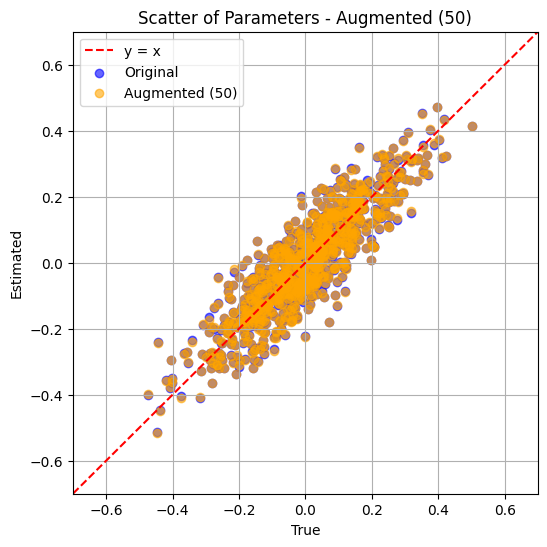

Augmented (50): MSE = 0.005777


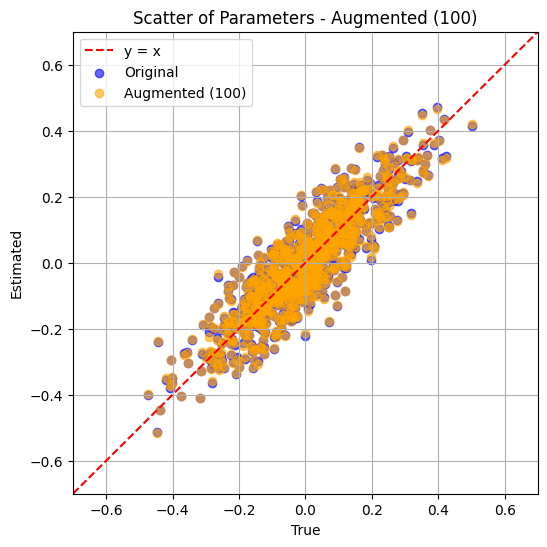

Augmented (100): MSE = 0.005781


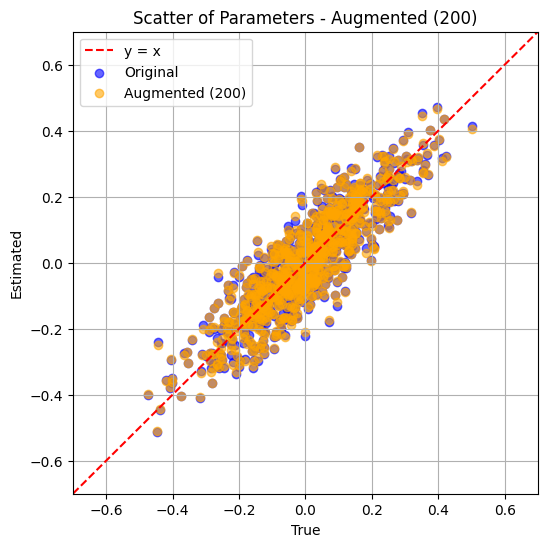

Augmented (200): MSE = 0.005750


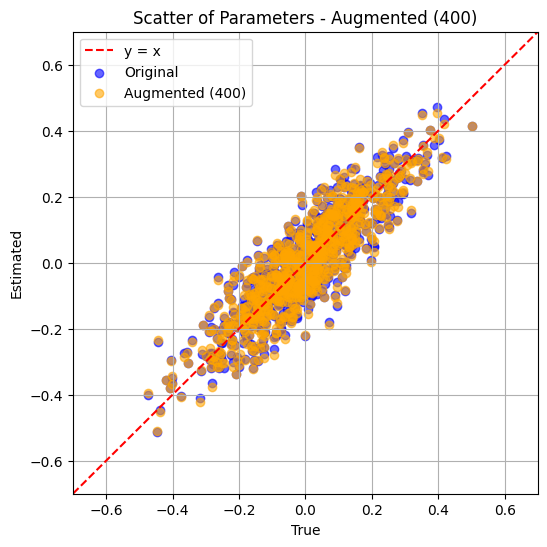

Augmented (400): MSE = 0.005742


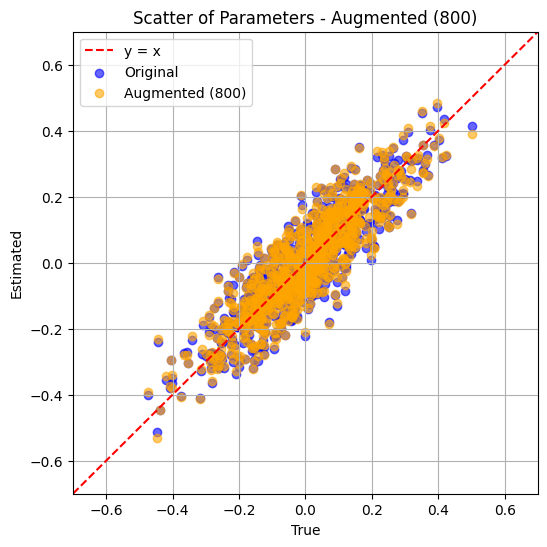

Augmented (800): MSE = 0.005776


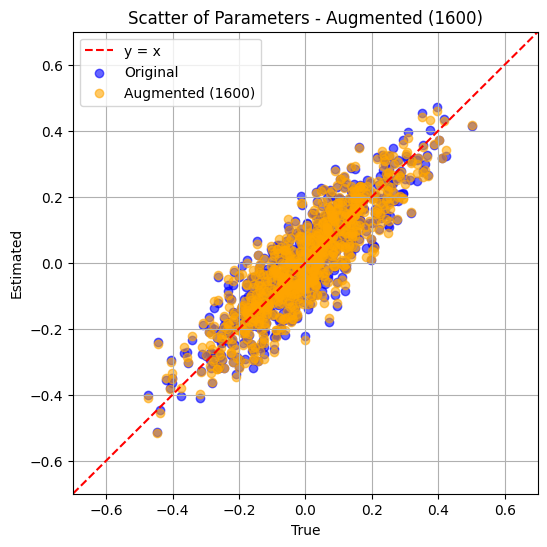

Augmented (1600): MSE = 0.005782


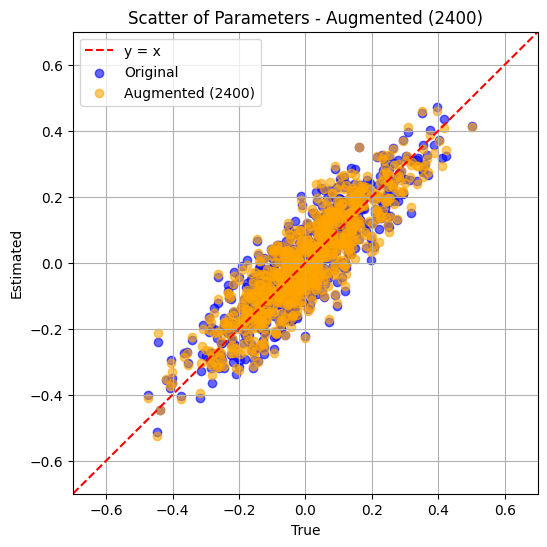

Augmented (2400): MSE = 0.005771


In [13]:
experiment()